<a href="https://colab.research.google.com/github/steph1793/DeepNeuralNet/blob/master/DeepNeuralNet_FromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network From Scratch

%%html
<img src="https://www.podcastscience.fm/wp-content/uploads/2015/09/Machine-Learning.jpg" width="600" >

In [0]:
import numpy as np
import math
import random


import gzip
import signal
import matplotlib.pyplot as plt


from tensorflow.keras.datasets import mnist # for mnist dataset
from random import randint



## MNIST dataset importation from tensorflow keras

In [0]:
mnist = mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

### We normalize and reshape the data

In [0]:
train_images, test_images = train_images/255.0, test_images/255.0
train_images = np.reshape(train_images, (-1,784))
test_images = np.reshape(test_images, (-1, 784))

In [0]:
def batches( x,y, batch_size):
  gather = list(zip(x,y))
  random.shuffle(gather)
  return [gather[i:i+batch_size] for i in range(0,len(gather),batch_size) ]

## Activations functions and their derivatives

In [0]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
  return sigmoid(z)*(1-sigmoid(z))

def softmax(z):
  res = [math.exp(i) for i in z]
  sum = np.sum(res)
  return res/sum

def softmax_derivative(z):
  return z # todo


def relu(z):
  return np.maximum(0,z)

def relu_derivative(z):
  return [0 if i<= 0 else 1 for i in z]

def leaky_relu(z):
  return [0.01*x if x<=0 else x for x in z ]

def leaky_relu_derivative(z):
  return [0.01 if i<= 0 else 1 for i in z]

In [0]:
sigmoid_pack = {'function' : sigmoid, 'derivative' :sigmoid_derivative }
softmax_pack = {'function' :softmax , 'derivative' :softmax_derivative }
relu_pack = {'function' :relu , 'derivative' :relu_derivative}
leaky_relu_pack =  {'function' : leaky_relu , 'derivative' : leaky_relu_derivative}

## Regularization functions

In [0]:
def L2(eta, lambd, training_size, weights):
  return (1 - eta*lambd /training_size)*weights

def L1(eta, lambd, training_size, weights):
  return (weights - eta*lambd/training_size*np.sign(weights))


## Cost functions and final layer deltas

In [0]:
def cross_entropy(a,y):
  return np.array(y) * np.array(math.log(a))

def cross_entropy_softmax_final_delta(z, a,y):
  return a-y


def MSE(a,y):
  return np.linalg.norm(a-y, 2)

def MSE_sigmoid_final_delta(z,a,y):
  np.array(sigmoid_derivative(z)) * np.array(a - y)

In [0]:
MSE_sigmoid_pack = {'function' : MSE, 'delta' :MSE_sigmoid_final_delta }
cross_entropy_softmax_pack = {'function' : cross_entropy, 'delta' : cross_entropy_softmax_final_delta }

## Simple neural network class

By default we use sigmoid function as an activation function

In [0]:
class Network:
  def __init__(self, sizes, activation = leaky_relu_pack, final_layer_activation=softmax_pack):
    self.layer_num = len(sizes)
    self.sizes = sizes ## layers sizes
    self.default_weights_initializer()


    self.activation = activation['function']
    self.final_layer_activation = final_layer_activation['function']

    self.activation_derivative = activation['derivative']
    self.final_layer_activation_derivative = final_layer_activation['derivative']


  def default_weights_initializer(self):
    sizes = self.sizes
    self.weights = [ np.random.randn(sizes[i+1], sizes[i])/np.sqrt(sizes[1]) for i in range(len(sizes)-1)]
    self.biases = [np.random.randn(sizes[i]) for i in range(1, len(sizes))]

  def large_weights_initializer(self):
    sizes = self.sizes
    self.weights = [ np.random.randn(sizes[i+1], sizes[i]) for i in range(self.layer_num-1)]
    self.biases = [np.random.randn(sizes[i]) for i in range(1, len(sizes))]


  def feedforward(self, x):
    a = x
    z_values = []
    a_values = []
    a_values.append(x)
    liste = list(zip(self.weights, self.biases))
    for w, b in liste[:-1] :
      z = np.dot(w, a) + b
      a = self.activation(z)
      a_values.append(a)
      z_values.append(z)
    w, b = liste[-1]
    z =  np.dot(w, a) + b
    a = self.final_layer_activation(z)
    a_values.append(a)
    z_values.append(z)
    return z_values, a_values



  def test(self, x):
    a = x
    liste = list(zip(self.weights, self.biases))
    for w,b in liste[:-1]:
      a = self.activation(np.dot(w,a)+b)
    w, b = liste[-1]
    a = self.final_layer_activation(np.dot(w,a)+b)
    return a



  def evaluate(self, test_data, test_labels):
    results = [(np.argmax(self.test(x)),y) for (x,y) in list(zip(test_data, test_labels))]
    return sum(int(x==y) for (x,y) in results)



## Optimizer class

In [0]:
class Optimizer:
  def __init__(self, net):
    self.net = net

  def backpropagate(self, z_values, out_err):
    deltas = []
    d = out_err
    deltas.append(d)
    for l in range(1,self.net.layer_num-1):
      d = np.multiply(np.dot(np.transpose(self.net.weights[-l]), d), self.net.activation_derivative(z_values[-l-1])) # we compute the deltas for each layer in the network except the first layer which corresponds to the input
      deltas.append(d)
    return deltas


  def gradient_descent(self, batch_deltas, batch_a_values, eta, batch_size,training_size, regular): # this function computes the gradient descent for one batch of data
    for l in range(1, self.net.layer_num):
      delta_w = 0
      delta_b = 0
      for deltas, a_values in list(zip(batch_deltas, batch_a_values)):
        d = deltas
        a = a_values[::-1]
        delta_w = delta_w + np.dot(np.asarray([d[l-1]]).transpose(), np.asarray([a[l]])) 
        delta_b = delta_b + d[l-1]
      if not regular:
        self.net.weights[-l] = self.net.weights[-l] -eta/batch_size*delta_w 
      else:
        self.net.weights[-l] = eval("{0}".format(regular[0]))(eta, regular[1], training_size, self.net.weights[-l]) - eta/batch_size*delta_w

      self.net.biases[-l] = self.net.biases[-l] - eta/batch_size*delta_b



  def Optimize(self, batch, eta, cost, training_size, regular):
    batch_deltas = []
    batch_a_values = []
    for x,y in batch:
      z_values, a_values = self.net.feedforward(x)
      final_delta = cost['delta'](z_values[-1], a_values[-1],y)
      deltas = self.backpropagate(z_values, final_delta)
      batch_deltas.append(deltas)
      batch_a_values.append(a_values)
    self.gradient_descent(batch_deltas, batch_a_values, eta, len(batch), training_size, regular)



## Training function

In [0]:
def train(network, optimizer, training_data, training_labels, batch_size, eta, epochs, test_data=[], test_labels=[], cost=cross_entropy_softmax_pack, regular=[]):
  for epoch in range(epochs):
    bs = batches(training_data, training_labels, batch_size)
    for mini_batch in bs:
      optimizer.Optimize(mini_batch, eta,cost, len(training_data), regular)
    if test_data.any() and test_labels.any() :
                              print("Epoch {0} : Accuracy => {1} / {2}".format(epoch, network.evaluate(test_data, test_labels), len(test_data) ))
    else :
                              print("Epoch {0}".format(epoch))



## Labels encoding (to hot vectors) and decoding (to integers)

In [0]:

def one_hot(labels):
	return [ [0 if i != j else 1 for i in range(10)] for j in labels]


def decode_output(y):
  return np.argmax(y)

## We create network and optimizer objects

In [0]:
net = Network([784,100,10]) ## Here we define the number of layers and their sizes
optimizer = Optimizer(net)

## Model training

In [0]:
#@title Hyperparameters

Batch_size = 100 #@param {type:"number"}
learning_rate = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
Epochs_num = 10 #@param {type:"number"}
lambda_ = 5 #@param {type:"slider", min:0, max:10, step:0.1}
Regularizer = "L2" #@param ["L1", "L2"]


In [16]:
train(net, optimizer, np.asarray(train_images), one_hot(train_labels),Batch_size,learning_rate,Epochs_num, np.asarray(test_images), np.asarray(test_labels), regular=[Regularizer,lambda_])


Epoch 0 : Accuracy => 9517 / 10000
Epoch 1 : Accuracy => 9645 / 10000
Epoch 2 : Accuracy => 9689 / 10000
Epoch 3 : Accuracy => 9721 / 10000
Epoch 4 : Accuracy => 9744 / 10000
Epoch 5 : Accuracy => 9748 / 10000
Epoch 6 : Accuracy => 9767 / 10000
Epoch 7 : Accuracy => 9779 / 10000
Epoch 8 : Accuracy => 9760 / 10000
Epoch 9 : Accuracy => 9764 / 10000


## Testing the model

We choose randomly some images in the test dataset and test them

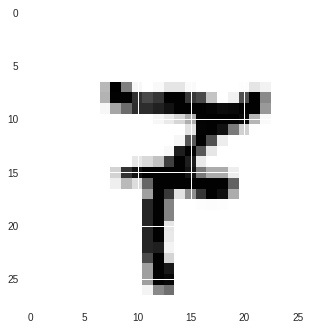

In [17]:
rand = randint(0,9999)
im=test_images[rand]
im = np.reshape(im, ( 28,28))
plt.imshow(im)

In [18]:
im = np.reshape(im, (784))
print("The decoded number")
print(decode_output(net.test(im)))

The decoded number
7
